#### WRF Example Notebook => single time slice

Demonstrates using ldcpy on a single hour from the wrf CONUS 404 data. 
(So simpler than WRFNotebook.ipynb as only 1 time dimension)

Also here we look at zfp also.

On NCAR's Jupyterhub, environment NPL 2024b is a good option (Note: it contains an old version of ldcpy that does not support WRF data.  So make sure you have a recent version from https://github.com/NCAR/ldcpy.)


In [1]:
import os
import sys

import cf_xarray as cf
import xarray as xr
import xwrf

%load_ext autoreload
%autoreload 2
%matplotlib inline

# loading our own ldcpy repo
sys.path.insert(0, '/glade/u/home/abaker/repos/my_ldcpy')
# suppress all of the divide by zero warnings
import warnings

# sys.path.insert(0, '/../../../')
import ldcpy

warnings.filterwarnings("ignore")

To look at SPERR- and zfp-compressed data, you need the HDF5 plugin installed and the path specified in HDF5_PLUGIN_PATH. You may have this variable set already in your environment.  If not, then set as needed.  Note that the plugin path is NOT required for the granualar bit rounding (GBR) approach.   

In [2]:
os.environ["HDF5_PLUGIN_PATH"]

'/glade/work/abaker/compress-libs/zfp_plugin/plugin'

In [3]:
# set as needed
zfp_plugin = '/glade/work/vanderwb/spack-downstreams/derecho/23.09/opt/spack/h5z-zfp/1.1.1/gcc/13.2.0/d5bw/plugin/'
sperr_plugin = '/glade/work/abaker/compress-libs/zfp_plugin/plugin'
both_casper = '/glade/work/abaker/compress-libs/casper_plugins'
os.environ['HDF5_PLUGIN_PATH'] = both_casper

In [4]:
# check
os.environ["HDF5_PLUGIN_PATH"]

'/glade/work/abaker/compress-libs/casper_plugins'

In [5]:
# if this environment variable is not set, then you can set it as needed:
os.environ['HDF5_PLUGIN_PATH'] = '/glade/work/abaker/compress-libs/casper_plugins'

In [6]:
# let's grab all the 2d data
# Some CONUS 404 wrf data to look at:
# (wrf2d_d01_2020-07-01_10:00:00  and then for 3d also)

# get the file names
mydir = "/glade/campaign/cisl/asap/abaker/wrf/wrf_hr10_compare/"
file2d = "wrf2d_d01_hr10.nc"
file3d = "wrf3d_d01_hr10.nc"

# original data (lossless)
orig_file2d = mydir + "lossless/" + file2d

# look at a granular bit rounded file w/1,2,3,4 sig figs
gbr1_file2d = mydir + "gbr1/" + file2d
gbr2_file2d = mydir + "gbr2/" + file2d
gbr3_file2d = mydir + "gbr3/" + file2d
gbr4_file2d = mydir + "gbr4/" + file2d

# look at a sperr file with pwe=1e-1, 1e-2, 1e-3, 1e-4
sp_pwe1_file2d = mydir + "sperr_pwe1e-1/" + file2d
sp_pwe2_file2d = mydir + "sperr_pwe1e-2/" + file2d
sp_pwe3_file2d = mydir + "sperr_pwe1e-3/" + file2d
sp_pwe4_file2d = mydir + "sperr_pwe1e-4/" + file2d

# zfp with p = 8,10,12,14,16,18,20,22
zfp_p8_file2d = mydir + "zfp_p8/" + file2d
zfp_p10_file2d = mydir + "zfp_p10/" + file2d
zfp_p12_file2d = mydir + "zfp_p12/" + file2d
zfp_p14_file2d = mydir + "zfp_p14/" + file2d
zfp_p16_file2d = mydir + "zfp_p16/" + file2d
zfp_p18_file2d = mydir + "zfp_p18/" + file2d
zfp_p20_file2d = mydir + "zfp_p20/" + file2d
zfp_p22_file2d = mydir + "zfp_p22/" + file2d

# this contains lat/lon info
fileconsts = mydir + "wrfconstants_usgs404.nc"

In [7]:
# file sizes? (optional to include in table when using collect datasets)
my_sizes = []
my_sizes.append(os.path.getsize(orig_file2d))

my_gbr_sizes = []
my_gbr_sizes.append(os.path.getsize(gbr1_file2d))
my_gbr_sizes.append(os.path.getsize(gbr2_file2d))
my_gbr_sizes.append(os.path.getsize(gbr3_file2d))
my_gbr_sizes.append(os.path.getsize(gbr4_file2d))

my_sp_sizes = []
my_sp_sizes.append(os.path.getsize(sp_pwe1_file2d))
my_sp_sizes.append(os.path.getsize(sp_pwe2_file2d))
my_sp_sizes.append(os.path.getsize(sp_pwe3_file2d))
my_sp_sizes.append(os.path.getsize(sp_pwe4_file2d))

my_zfp_sizes = []
my_zfp_sizes.append(os.path.getsize(zfp_p8_file2d))
my_zfp_sizes.append(os.path.getsize(zfp_p10_file2d))
my_zfp_sizes.append(os.path.getsize(zfp_p12_file2d))
my_zfp_sizes.append(os.path.getsize(zfp_p14_file2d))
my_zfp_sizes.append(os.path.getsize(zfp_p16_file2d))
my_zfp_sizes.append(os.path.getsize(zfp_p18_file2d))
my_zfp_sizes.append(os.path.getsize(zfp_p20_file2d))
my_zfp_sizes.append(os.path.getsize(zfp_p22_file2d))

In [8]:
# file sizes
print(my_sizes)
print(my_gbr_sizes)
print(my_sp_sizes)
print(my_zfp_sizes)

[405572116]
[78888760, 118417463, 188130776, 242674975]
[184501676, 232447634, 284432232, 339822593]
[101909582, 126344005, 153753167, 183855814, 215304137, 247425330, 279959987, 312746899]


In [9]:
# CR - compression ratios (Note: these are for the entire file, different variable may c compress with different ratios)
orig = my_sizes[0]
gbr_cr = []
for i in my_gbr_sizes:
    gbr_cr.append(orig / i)
print("GBR CR: ", gbr_cr)
sp_cr = []
for i in my_sp_sizes:
    sp_cr.append(orig / i)
print("SPERR CR: ", sp_cr)
zfp_cr = []
for i in my_zfp_sizes:
    zfp_cr.append(orig / i)
print("ZFP CR: ", zfp_cr)

GBR CR:  [5.141063391033146, 3.4249350199302953, 2.1557988789670435, 1.6712564449630622]
SPERR CR:  [2.1982028824496966, 1.744789176903388, 1.4259006904674574, 1.1934819060132356]
ZFP CR:  [3.979725046855751, 3.2100622107079793, 2.637813086477757, 2.2059248885107325, 1.8837172459904938, 1.6391697487076202, 1.448678864240696, 1.2968061947114622]


In [10]:
# open all files as a dataset and process with xwrf for use with xarray
ds_orig = xr.open_dataset(orig_file2d, engine="netcdf4").xwrf.postprocess()

ds_gbr1 = xr.open_dataset(gbr1_file2d, engine="netcdf4").xwrf.postprocess()
ds_gbr2 = xr.open_dataset(gbr2_file2d, engine="netcdf4").xwrf.postprocess()
ds_gbr3 = xr.open_dataset(gbr3_file2d, engine="netcdf4").xwrf.postprocess()
ds_gbr4 = xr.open_dataset(gbr4_file2d, engine="netcdf4").xwrf.postprocess()

ds_sp_pwe1 = xr.open_dataset(sp_pwe1_file2d, engine="netcdf4").xwrf.postprocess()
ds_sp_pwe2 = xr.open_dataset(sp_pwe2_file2d, engine="netcdf4").xwrf.postprocess()
ds_sp_pwe3 = xr.open_dataset(sp_pwe3_file2d, engine="netcdf4").xwrf.postprocess()
ds_sp_pwe4 = xr.open_dataset(sp_pwe4_file2d, engine="netcdf4").xwrf.postprocess()

ds_zfp_p8 = xr.open_dataset(zfp_p8_file2d, engine="netcdf4").xwrf.postprocess()
ds_zfp_p10 = xr.open_dataset(zfp_p10_file2d, engine="netcdf4").xwrf.postprocess()
ds_zfp_p12 = xr.open_dataset(zfp_p12_file2d, engine="netcdf4").xwrf.postprocess()
ds_zfp_p14 = xr.open_dataset(zfp_p14_file2d, engine="netcdf4").xwrf.postprocess()
ds_zfp_p16 = xr.open_dataset(zfp_p16_file2d, engine="netcdf4").xwrf.postprocess()
ds_zfp_p18 = xr.open_dataset(zfp_p18_file2d, engine="netcdf4").xwrf.postprocess()
ds_zfp_p20 = xr.open_dataset(zfp_p20_file2d, engine="netcdf4").xwrf.postprocess()
ds_zfp_p22 = xr.open_dataset(zfp_p22_file2d, engine="netcdf4").xwrf.postprocess()


# coordinates
ds_const = xr.open_dataset(fileconsts, engine="netcdf4").xwrf.postprocess()

In [11]:
# make an ldcpy collection of all of this data to compare data (and pick a few variables to load).
# Passing in the file sizes is optional, but allows you to compare compression rates in the tables - here we are comparing
# to the lossless size
combine_col = ldcpy.collect_datasets(
    "wrf",
    ["T2", "U10", "Q2", "V10", "U", "V", "SNLIQ", "ACECAN", "RAINNCV", "LWUPT"],
    [
        ds_orig,
        ds_gbr1,
        ds_gbr2,
        ds_gbr3,
        ds_gbr4,
        ds_sp_pwe1,
        ds_sp_pwe2,
        ds_sp_pwe3,
        ds_sp_pwe4,
        ds_zfp_p8,
        ds_zfp_p10,
        ds_zfp_p12,
        ds_zfp_p14,
        ds_zfp_p16,
        ds_zfp_p18,
        ds_zfp_p20,
        ds_zfp_p22,
    ],
    [
        "lossless",
        "gbr1",
        "gbr2",
        "gbr3",
        "gbr4",
        "sperr_pwe1e-1",
        "sperr_pwe1e-2",
        "sperr_pwe1e-3",
        "sperr_pwe1e-4",
        "zfp_p8",
        "zfp_p10",
        "zfp_p12",
        "zfp_p14",
        "zfp_p16",
        "zfp_p18",
        "zfp_p20",
        "zfp_p22",
    ],
    coords_ds=ds_const,
    file_sizes=my_sizes + my_gbr_sizes + my_sp_sizes + my_zfp_sizes,
)

dataset size in GB 1.17



In [12]:
# quick look at collection dataset
combine_col

<xarray.Dataset> Size: 1GB
Dimensions:     (collection: 17, Time: 1, y: 1015, x: 1367, x_stag: 1368,
                 y_stag: 1016, snow_layers_stag: 3)
Coordinates: (12/13)
    XTIME       (Time) datetime64[ns] 8B 2020-07-01T10:00:00
  * Time        (Time) datetime64[ns] 8B 2020-07-01T10:00:00
    XLAT        (y, x) float32 6MB 17.65 17.66 17.67 17.68 ... 51.73 51.71 51.69
    XLONG       (y, x) float32 6MB -122.6 -122.5 -122.5 ... -57.17 -57.12 -57.07
    XLAT_U      (y, x_stag) float32 6MB 17.64 17.65 17.66 ... 51.72 51.7 51.69
    XLONG_U     (y, x_stag) float32 6MB -122.6 -122.6 -122.5 ... -57.09 -57.04
    ...          ...
    XLONG_V     (y_stag, x) float32 6MB -122.6 -122.5 -122.5 ... -57.11 -57.06
  * x           (x) float64 11kB -2.732e+06 -2.728e+06 ... 2.728e+06 2.732e+06
  * y_stag      (y_stag) float64 8kB -2.03e+06 -2.026e+06 ... 2.026e+06 2.03e+06
  * y           (y) float64 8kB -2.028e+06 -2.024e+06 ... 2.024e+06 2.028e+06
  * x_stag      (x_stag) float64 11kB -2.734e+06 -2.73e+06 ... 2.734e+06
  * collection  (collection) <U13 884B 'lossless' 'gbr1' ... 'zfp_p20' 'zfp_p22'
Dimensions without coordinates: snow_layers_stag
Data variables:
    T2          (collection, Time, y, x) float32 94MB 297.2 297.2 ... 290.0
    U10         (collection, Time, y, x) float32 94MB -3.558 -3.569 ... 2.997
    Q2          (collection, Time, y, x) float32 94MB 0.01766 ... 0.009758
    V10         (collection, Time, y, x) float32 94MB -2.062 -2.079 ... 3.633
    U           (collection, Time, y, x_stag) float32 94MB -3.737 ... 3.579
    V           (collection, Time, y_stag, x) float32 94MB -2.181 ... 4.092
    SNLIQ       (collection, Time, snow_layers_stag, y, x) float32 283MB 0.0 ...
    ACECAN      (collection, Time, y, x) float32 94MB 0.0 0.0 0.0 ... 0.0 0.0
    RAINNCV     (collection, Time, y, x) float32 94MB 0.0 0.0 0.0 ... 0.0 0.0
    LWUPT       (collection, Time, y, x) float32 94MB 278.5 278.5 ... 195.9
Attributes: (12/152)
    TITLE:                            OUTPUT FROM WRF V3.9.1.1 MODEL
    START_DATE:                      2020-07-01_00:00:00
    SIMULATION_START_DATE:           1979-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1368
    SOUTH-NORTH_GRID_DIMENSION:      1016
    BOTTOM-TOP_GRID_DIMENSION:       51
    ...                              ...
    history:                         Thu Sep 12 14:32:49 2024: ncap2 -s where...
    history_of_appended_files:       Wed May  4 13:20:54 2022: Appended file ...
    cell_measures:                   area: cell_area
    data_type:                       wrf
    file_size:                       {'lossless': 405572116, 'gbr1': 78888760...
    weighted:                        False

In [13]:
# grab time slice of interest (only 1)
col_time = combine_col.isel(Time=0)

In [14]:
# look at variable T2 statistics at 12 hours, we'll compare the bit grooming variants first
# we use the label we passed in when creating this collection
# gbr1 is the most aggressive and gbr4 is the least
# gbr# = Granular Bit Rounding with # significant digits preserved

#
# view chart of statistics
ldcpy.compare_stats(
    col_time,
    "T2",
    ["lossless", "gbr1", "gbr2", "gbr3", "gbr4"],
    significant_digits=7,
    aggregate_dims=["y", "x"],
)

lossless         gbr1         gbr2  \
mean                              292.0796       302.89     292.3486   
variance                          41.77716     802.2868     52.18255   
standard deviation                6.463528     28.32468     7.223752   
min value                         267.7219          256          264   
min (abs) nonzero value           267.7219          256          264   
max value                         304.6539          320          304   
probability positive                     1            1            1   
number of zeros                          0            0            0   
99% real information cutoff bit         19           11           14   
entropy estimate                 0.3857764  0.004171697  0.007885197   

                                       gbr3       gbr4  
mean                               292.0775   292.0796  
variance                           41.83374   41.77721  
standard deviation                 6.467903   6.463532  
min value                               268     267.75  
min (abs) nonzero value                 268     267.75  
max value                               305    304.625  
probability positive                      1          1  
number of zeros                           0          0  
99% real information cutoff bit          17         19  
entropy estimate                 0.03564564  0.1304527

gbr1        gbr2          gbr3  \
max abs diff                                32           4           0.5   
min abs diff                          11.72189           0             0   
mean abs diff                          25.7296     2.12005     0.2495679   
mean squared diff                      116.865  0.07235283  4.719345e-06   
root mean squared diff                26.09817    2.401136     0.2883064   
normalized root mean squared diff    0.7066546  0.06501505   0.007806411   
normalized max pointwise error       0.8664563   0.1083063    0.01353757   
pearson correlation coefficient      0.7641974   0.9452231     0.9990061   
ks p-value                                   0           0             0   
spatial relative error(% > 0.0001)         100     99.3884      94.13177   
max spatial relative error           0.1111111  0.01449264   0.001848204   
DSSIM                               0.02933683   0.1254212     0.5957748   
file size ratio                           5.14        3.42          2.16   

                                            gbr4  
max abs diff                             0.03125  
min abs diff                                   0  
mean abs diff                         0.01562176  
mean squared diff                   9.242483e-11  
root mean squared diff                0.01803965  
normalized root mean squared diff   0.0004884558  
normalized max pointwise error      0.0008453232  
pearson correlation coefficient        0.9999961  
ks p-value                          3.412358e-10  
spatial relative error(% > 0.0001)      6.541166  
max spatial relative error          0.0001144226  
DSSIM                                  0.9276372  
file size ratio                             1.67

In [16]:
# let's look at the sperr results for T2  (note these could be in the same table as the gbr results, \
# and the table would just be larger)
# sperr_pweX = sperr with pointwise error tolerance X

# view chart of statistics
ldcpy.compare_stats(
    col_time,
    "T2",
    [
        "lossless",
        "sperr_pwe1e-1",
        "sperr_pwe1e-2",
        "sperr_pwe1e-3",
        "sperr_pwe1e-4",
    ],
    significant_digits=7,
    aggregate_dims=["y", "x"],
)

lossless sperr_pwe1e-1 sperr_pwe1e-2  \
mean                              292.0796      292.0796      292.0796   
variance                          41.77716      41.77868      41.77724   
standard deviation                6.463528      6.463646      6.463534   
min value                         267.7219      267.7603      267.7208   
min (abs) nonzero value           267.7219      267.7603      267.7208   
max value                         304.6539      304.6402      304.6519   
probability positive                     1             1             1   
number of zeros                          0             0             0   
99% real information cutoff bit         19            19            19   
entropy estimate                 0.3857764     0.3857573     0.3857391   

                                sperr_pwe1e-3 sperr_pwe1e-4  
mean                                 292.0796      292.0796  
variance                             41.77716      41.77716  
standard deviation                   6.463528      6.463528  
min value                            267.7218      267.7219  
min (abs) nonzero value              267.7218      267.7219  
max value                            304.6534      304.6538  
probability positive                        1             1  
number of zeros                             0             0  
99% real information cutoff bit            19            19  
entropy estimate                    0.3857633     0.3857419

sperr_pwe1e-1 sperr_pwe1e-2 sperr_pwe1e-3  \
max abs diff                           0.1000061    0.01000977    0.00100708   
min abs diff                                   0             0             0   
mean abs diff                         0.02844488   0.003251816  0.0003333391   
mean squared diff                   1.835625e-10   1.01429e-11    2.1522e-16   
root mean squared diff                0.03614982   0.004014234  0.0004100812   
normalized root mean squared diff   0.0009788209  0.0001086925  1.110368e-05   
normalized max pointwise error       0.002707844  0.0002710323  2.726849e-05   
pearson correlation coefficient        0.9999844     0.9999998             1   
ks p-value                                     1             1             1   
spatial relative error(% > 0.0001)      40.48245             0             0   
max spatial relative error          0.0003646224  3.651303e-05  3.700878e-06   
DSSIM                                  0.9082179     0.9843193     0.9981921   
file size ratio                              2.2          1.74          1.43   

                                   sperr_pwe1e-4  
max abs diff                        9.155273e-05  
min abs diff                                   0  
mean abs diff                       3.257827e-05  
mean squared diff                   1.609462e-15  
root mean squared diff              4.194769e-05  
normalized root mean squared diff   1.135809e-06  
normalized max pointwise error      2.478954e-06  
pearson correlation coefficient                1  
ks p-value                                     1  
spatial relative error(% > 0.0001)             0  
max spatial relative error          3.389618e-07  
DSSIM                                  0.9998288  
file size ratio                             1.19

In [18]:
# finally zfp
# view chart of statistics
ldcpy.compare_stats(
    col_time,
    "T2",
    ["lossless", "zfp_p8", "zfp_p10", "zfp_p12", "zfp_p14", "zfp_p16", "zfp_p18"],
    significant_digits=7,
    aggregate_dims=["y", "x"],
)

lossless       zfp_p8     zfp_p10  \
mean                              292.0796     292.3321    292.0985   
variance                          41.77716      51.5829    42.34952   
standard deviation                6.463528     7.182126    6.507653   
min value                         267.7219          272       266.5   
min (abs) nonzero value           267.7219          272       266.5   
max value                         304.6539          308       307.5   
probability positive                     1            1           1   
number of zeros                          0            0           0   
99% real information cutoff bit         19           14          17   
entropy estimate                 0.3857764  0.004233859  0.01179798   

                                    zfp_p12    zfp_p14    zfp_p16    zfp_p18  
mean                               292.0798   292.0796   292.0796   292.0796  
variance                           41.80373   41.78531   41.77778    41.7772  
standard deviation                 6.465583   6.464158   6.463575   6.463531  
min value                           268.375   267.8047   267.7754   267.7314  
min (abs) nonzero value             268.375   267.8047   267.7754   267.7314  
max value                          304.6875   304.6406   304.6309   304.6426  
probability positive                      1          1          1          1  
number of zeros                           0          0          0          0  
99% real information cutoff bit          22         24         26         28  
entropy estimate                 0.05652313  0.1481023  0.2378295  0.3026745

zfp_p8       zfp_p10       zfp_p12  \
max abs diff                          12.88269      8.342102      2.622498   
min abs diff                                 0             0             0   
mean abs diff                         2.173521     0.6402706     0.2522318   
mean squared diff                   0.06374488  0.0003543805  2.001098e-08   
root mean squared diff                2.489282     0.8162276     0.3461459   
normalized root mean squared diff   0.06740175    0.02210082   0.009372517   
normalized max pointwise error       0.3488218     0.2258773     0.0710088   
pearson correlation coefficient       0.939507     0.9921078     0.9985665   
ks p-value                                   0             0             0   
spatial relative error(% > 0.0001)     99.3897      97.48786       91.7294   
max spatial relative error          0.04459489    0.02853541   0.009412368   
DSSIM                               0.05626657     0.2275259     0.5376311   
file size ratio                           3.98          3.21          2.64   

                                         zfp_p14       zfp_p16       zfp_p18  
max abs diff                           0.6876221     0.1622314    0.04122925  
min abs diff                                   0             0             0  
mean abs diff                         0.08927056    0.02622932   0.007074184  
mean squared diff                   3.166986e-10  1.567541e-10  8.754474e-11  
root mean squared diff                   0.11746    0.03332514   0.008868926  
normalized root mean squared diff    0.003180439  0.0009023377   0.000240142  
normalized max pointwise error        0.01861859   0.004392706   0.001060166  
pearson correlation coefficient        0.9998349     0.9999867     0.9999991  
ks p-value                          3.344915e-29     0.4631586             1  
spatial relative error(% > 0.0001)      76.71821       36.6847    0.07783756  
max spatial relative error           0.002316322  0.0005609638  0.0001465688  
DSSIM                                  0.7891301     0.9059703     0.9667853  
file size ratio                             2.21          1.88          1.64

In [20]:
# let's put results for T2 with similar CR in the same table
ldcpy.compare_stats(
    col_time,
    "T2",
    ["lossless", "gbr3", "sperr_pwe1e-1", "zfp_p14"],
    significant_digits=5,
    aggregate_dims=["y", "x"],
)

lossless      gbr3 sperr_pwe1e-1 zfp_p14
mean                              292.08    292.08        292.08  292.08
variance                          41.777    41.834        41.779  41.785
standard deviation                6.4635    6.4679        6.4636  6.4642
min value                         267.72       268        267.76   267.8
min (abs) nonzero value           267.72       268        267.76   267.8
max value                         304.65       305        304.64  304.64
probability positive                   1         1             1       1
number of zeros                        0         0             0       0
99% real information cutoff bit       19        17            19      24
entropy estimate                 0.38578  0.035646       0.38576  0.1481

gbr3 sperr_pwe1e-1     zfp_p14
max abs diff                               0.5       0.10001     0.68762
min abs diff                                 0             0           0
mean abs diff                          0.24957      0.028445    0.089271
mean squared diff                   4.7193e-06    1.8356e-10   3.167e-10
root mean squared diff                 0.28831       0.03615     0.11746
normalized root mean squared diff    0.0078064    0.00097882   0.0031804
normalized max pointwise error        0.013538     0.0027078    0.018619
pearson correlation coefficient        0.99901       0.99998     0.99983
ks p-value                                   0             1  3.3449e-29
spatial relative error(% > 0.0001)      94.132        40.482      76.718
max spatial relative error           0.0018482    0.00036462   0.0023163
DSSIM                                  0.59577       0.90822     0.78913
file size ratio                           2.16           2.2        2.21

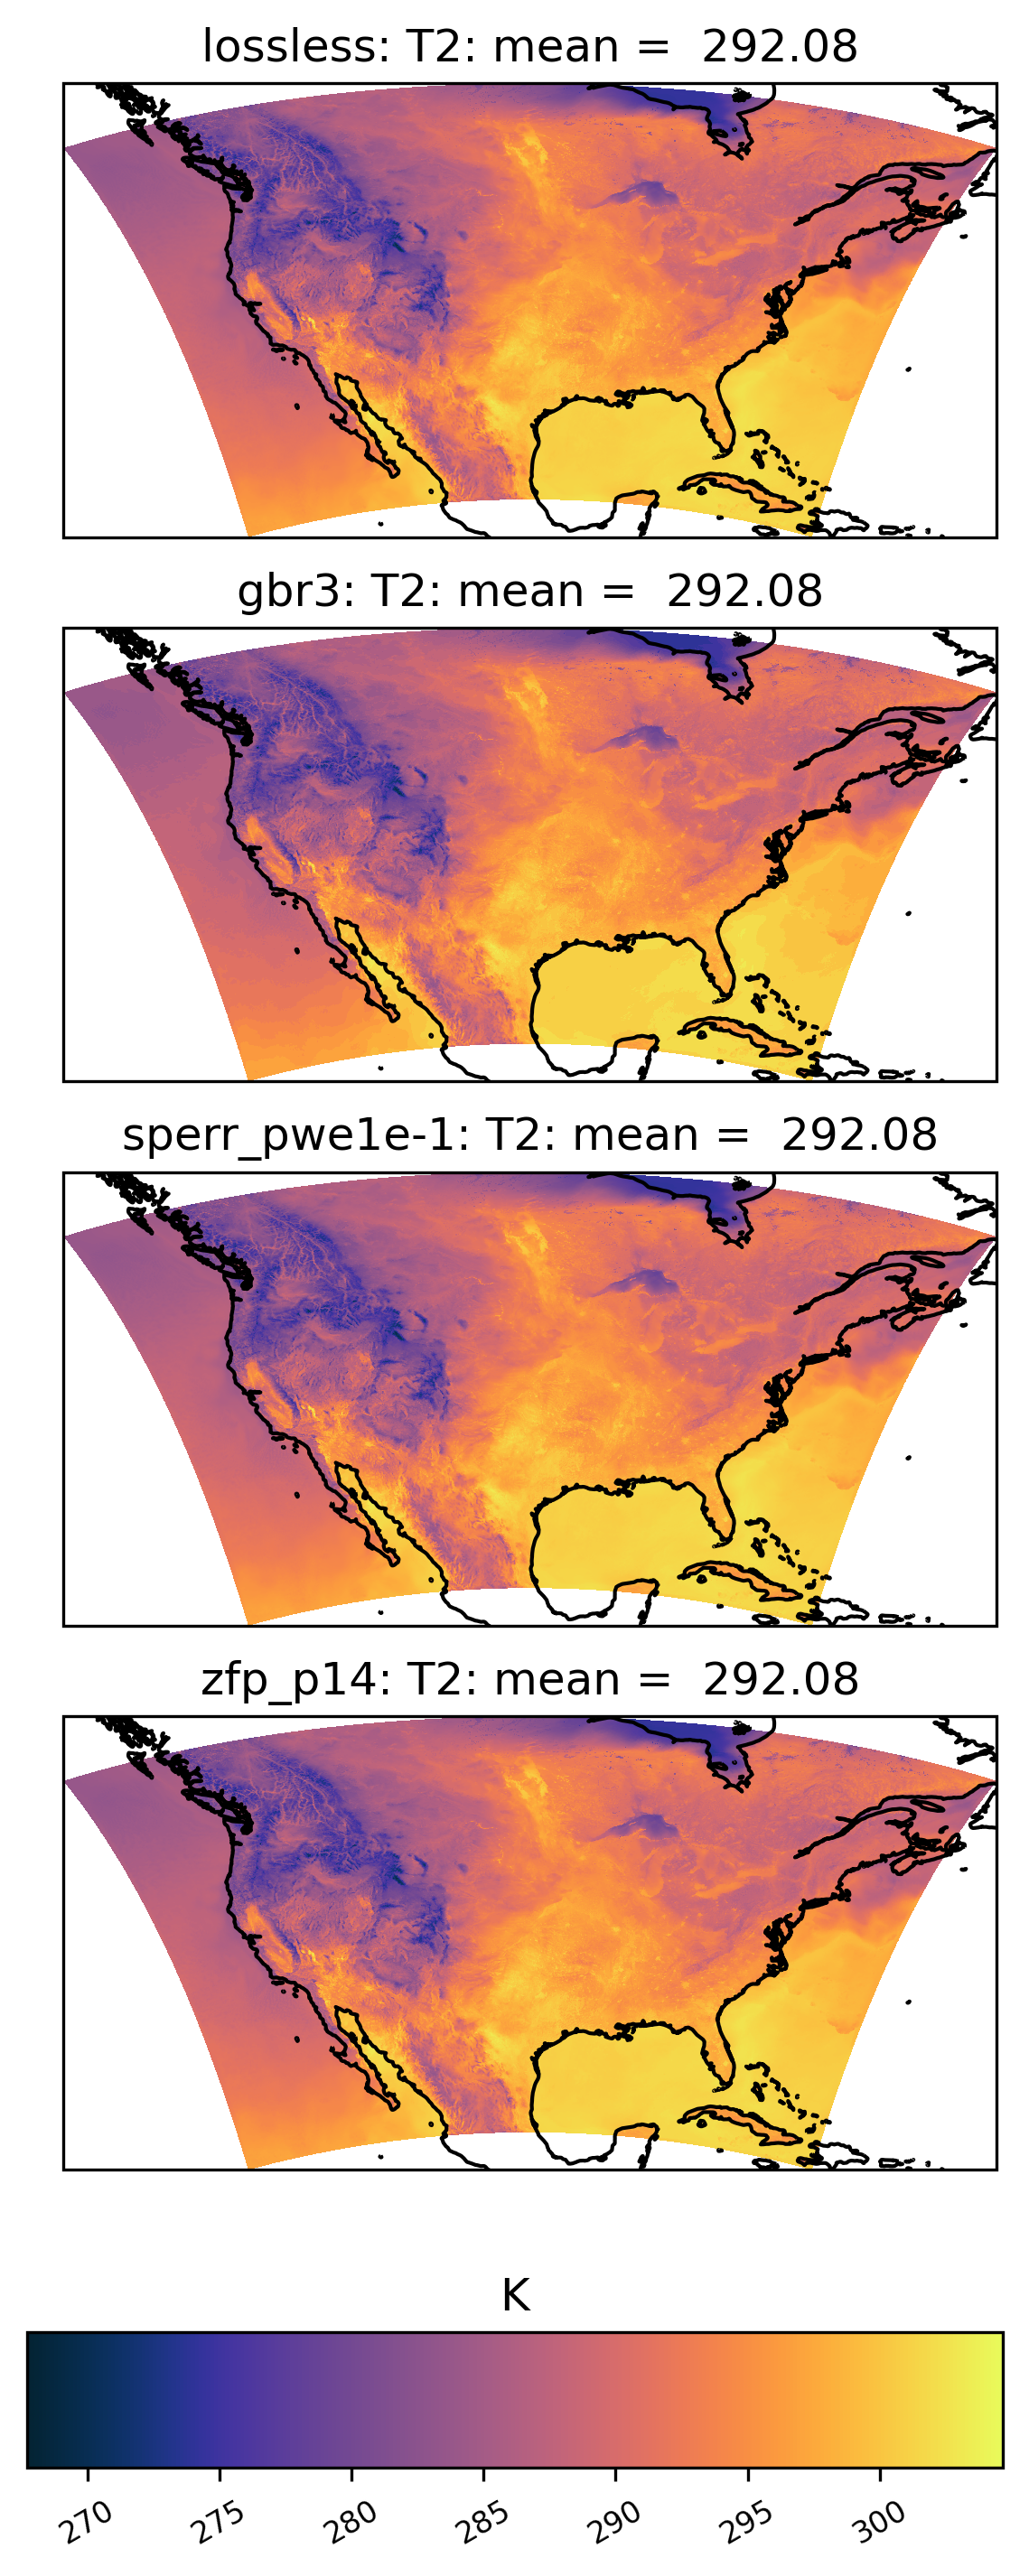

In [16]:
# plot mean T2 field for several compression options
ldcpy.plot(
    combine_col,
    "T2",
    sets=["lossless", "gbr3", "sperr_pwe1e-1", "zfp_p14"],
    calc="mean",
    plot_type="spatial",
    color="cmo.thermal",
    vert_plot=True,
)

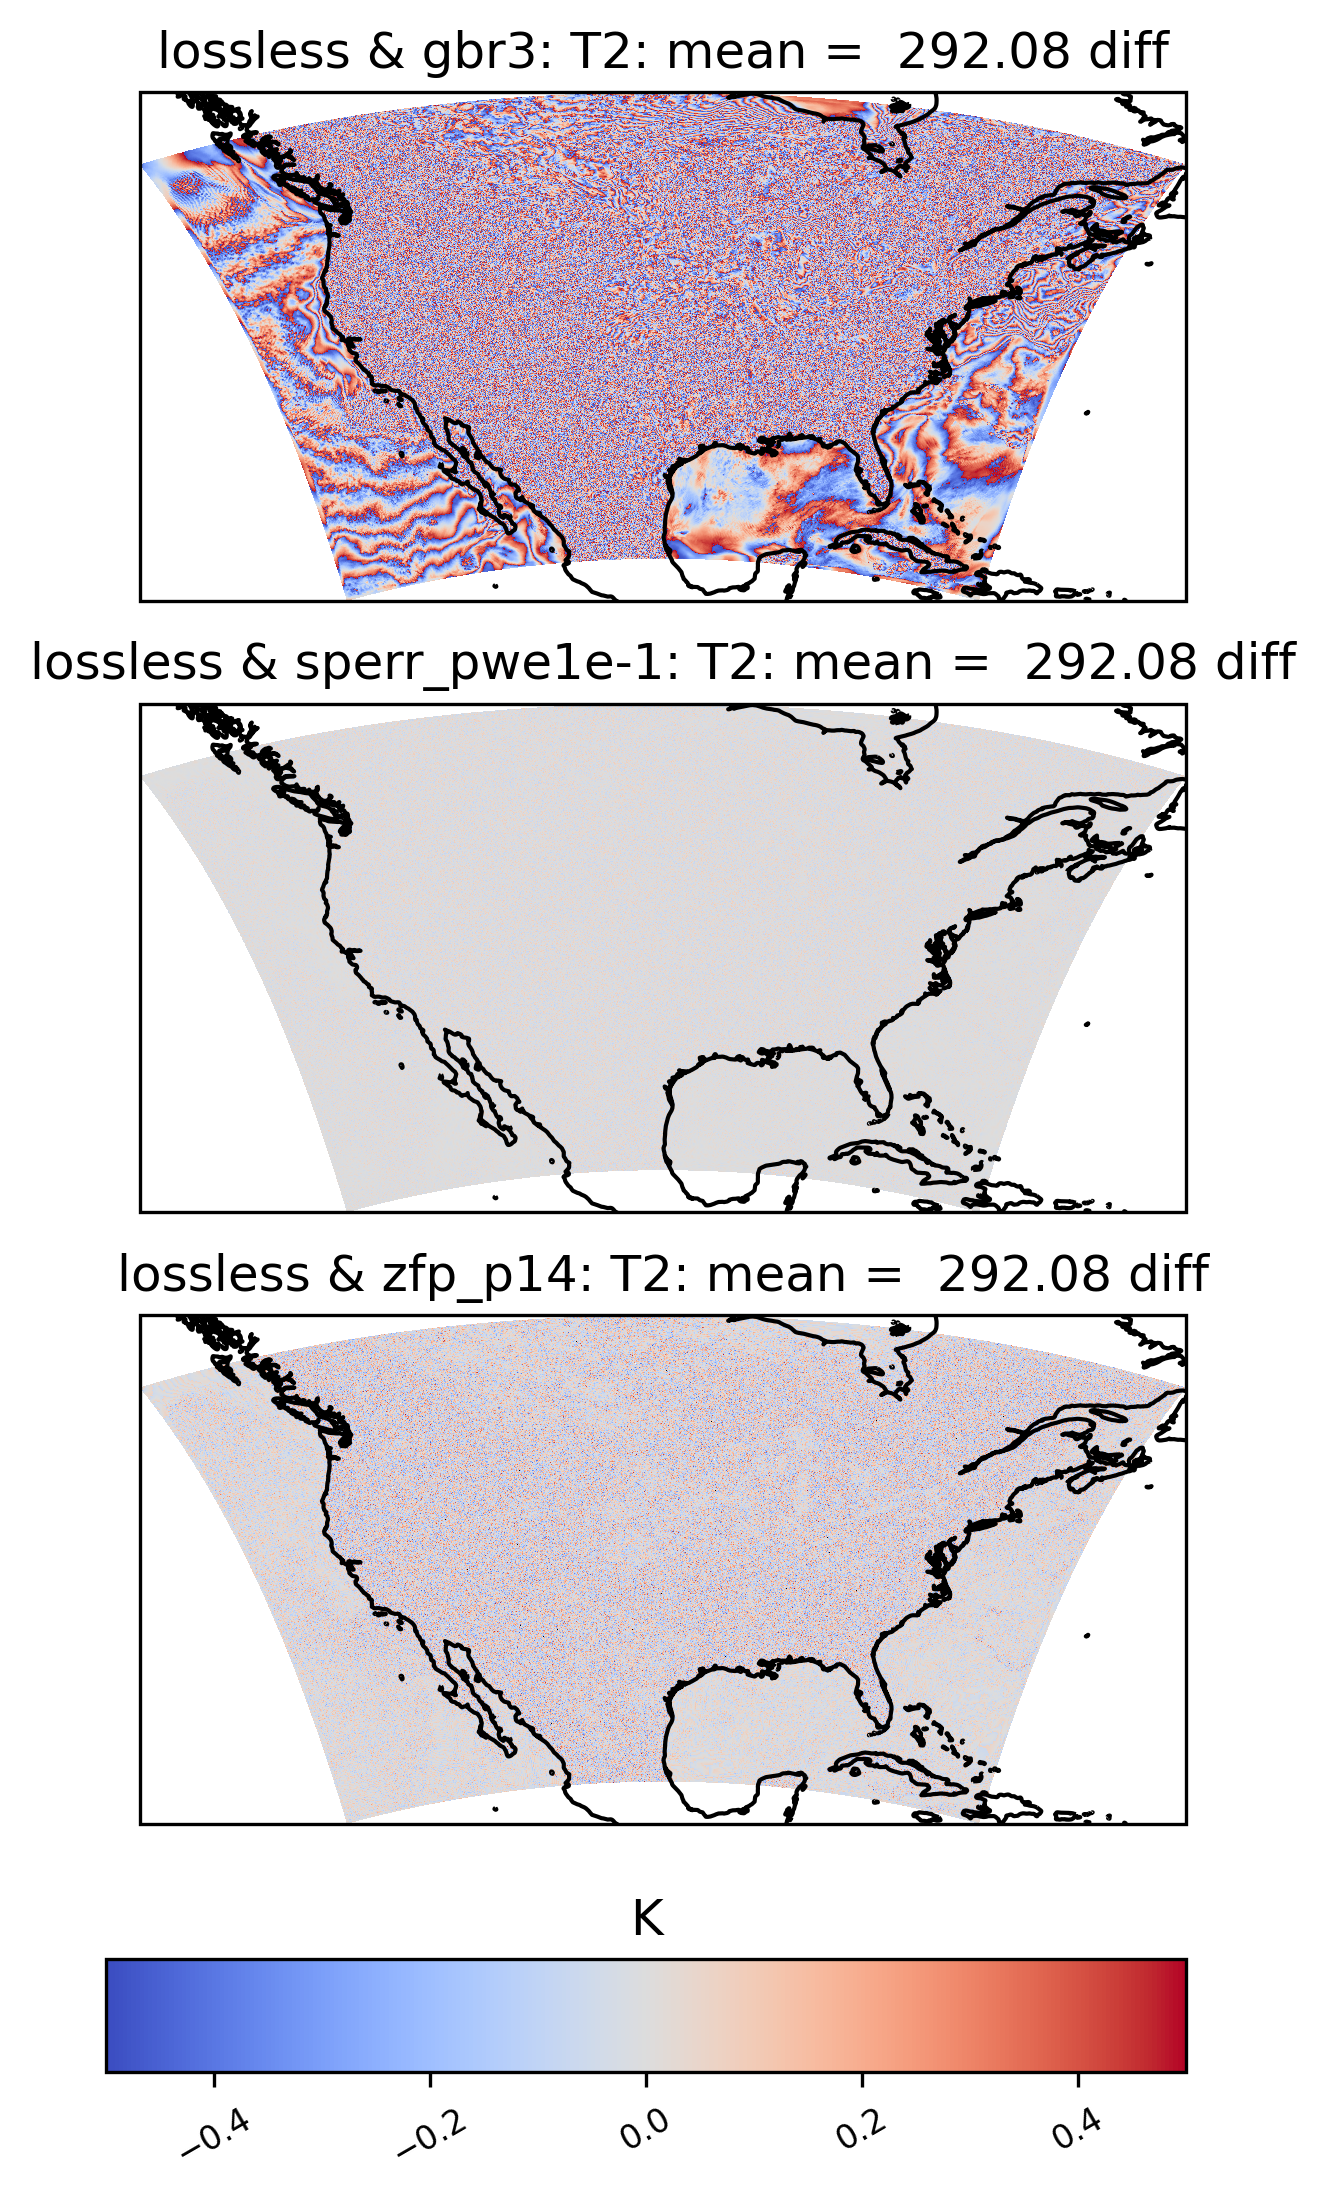

In [17]:
# Plot the differences for T2
ldcpy.plot(
    combine_col,
    "T2",
    sets=["lossless", "gbr3", "sperr_pwe1e-1", "zfp_p14"],
    calc="mean",
    calc_type="diff",
    plot_type="spatial",
    vert_plot=True,
)

In [40]:
# let's look at RAINNCV - many zeros and small numbers

In [45]:
# view chart of statistics - first for GBR
ldcpy.compare_stats(
    col_time,
    "RAINNCV",
    ["lossless", "gbr1", "gbr2", "gbr3", "gbr4"],
    significant_digits=7,
    aggregate_dims=["y", "x"],
)

lossless          gbr1          gbr2  \
mean                              0.000588153   0.000588579  0.0005881359   
variance                         6.221204e-05   6.24447e-05  6.220475e-05   
standard deviation                0.007887464   0.007902199   0.007887002   
min value                                   0             0             0   
min (abs) nonzero value          1.301931e-12  9.094947e-13  1.307399e-12   
max value                           0.9965089             1             1   
probability positive                0.2565728     0.2565728     0.2565728   
number of zeros                       1031509       1031509       1031509   
99% real information cutoff bit            31            11            14   
entropy estimate                      0.16069    0.04609731    0.07292622   

                                         gbr3          gbr4  
mean                             0.0005881592  0.0005881532  
variance                         6.221505e-05  6.221203e-05  
standard deviation                0.007887654   0.007887463  
min value                                   0             0  
min (abs) nonzero value          1.300293e-12   1.30207e-12  
max value                           0.9960938      0.996521  
probability positive                0.2565728     0.2565728  
number of zeros                       1031509       1031509  
99% real information cutoff bit            17            20  
entropy estimate                   0.09417299     0.1096583

gbr1          gbr2          gbr3  \
max abs diff                          0.03122948   0.003903404  0.0004877597   
min abs diff                                   0             0             0   
mean abs diff                       4.415813e-05  5.000689e-06  4.469401e-07   
mean squared diff                   1.815023e-13  2.927357e-16  3.858286e-17   
root mean squared diff              0.0005794288   7.33776e-05  8.563406e-06   
normalized root mean squared diff   0.0005814587  7.363466e-05  8.593407e-06   
normalized max pointwise error        0.03133889   0.003917079  0.0004894685   
pearson correlation coefficient        0.9973084     0.9999567     0.9999994   
ks p-value                          2.871944e-43     0.1650174             1   
spatial relative error(% > 0.0001)      25.62931      25.39285      22.92208   
max spatial relative error             0.3333302    0.04760725   0.004732507   
DSSIM                                  0.9809175     0.9989221     0.9999104   
file size ratio                             5.14          3.42          2.16   

                                            gbr4  
max abs diff                        3.051758e-05  
min abs diff                                   0  
mean abs diff                       4.186831e-08  
mean squared diff                   3.557969e-20  
root mean squared diff              5.797883e-07  
normalized root mean squared diff   5.818195e-07  
normalized max pointwise error      3.054225e-05  
pearson correlation coefficient                1  
ks p-value                                     1  
spatial relative error(% > 0.0001)      6.595219  
max spatial relative error          0.0004699971  
DSSIM                                  0.9999971  
file size ratio                             1.67

In [18]:
# view chart of statistics - now for sperr
ldcpy.compare_stats(
    col_time,
    "RAINNCV",
    [
        "lossless",
        "sperr_pwe1e-1",
        "sperr_pwe1e-2",
        "sperr_pwe1e-3",
        "sperr_pwe1e-4",
    ],
    significant_digits=5,
    aggregate_dims=["y", "x"],
)

lossless sperr_pwe1e-1 sperr_pwe1e-2  \
mean                             0.00058815     0.0010173    0.00059629   
variance                         6.2212e-05    6.3365e-05    6.2497e-05   
standard deviation                0.0078875     0.0079602     0.0079055   
min value                                 0      -0.09769    -0.0099561   
min (abs) nonzero value          1.3019e-12    3.1262e-09    4.0278e-10   
max value                           0.99651        1.0427        0.9928   
probability positive                0.25657       0.90249       0.59882   
number of zeros                  1.0315e+06             0             0   
99% real information cutoff bit          31            30            13   
entropy estimate                    0.16069       0.35057       0.52052   

                                sperr_pwe1e-3 sperr_pwe1e-4  
mean                               0.00058834    0.00058815  
variance                           6.2223e-05    6.2212e-05  
standard deviation                  0.0078882     0.0078875  
min value                         -0.00099681    -9.996e-05  
min (abs) nonzero value            3.2694e-11    2.5798e-14  
max value                             0.99737       0.99659  
probability positive                   0.6201       0.58078  
number of zeros                             0             0  
99% real information cutoff bit            10            10  
entropy estimate                      0.54271       0.54679

sperr_pwe1e-1 sperr_pwe1e-2 sperr_pwe1e-3  \
max abs diff                            0.099921     0.0099985    0.00099983   
min abs diff                          3.1262e-09    4.0278e-10    3.2694e-11   
mean abs diff                          0.0011619    0.00028881    5.7419e-05   
mean squared diff                      1.842e-07    6.6219e-11    3.5085e-14   
root mean squared diff                 0.0032572     0.0007116    0.00012439   
normalized root mean squared diff      0.0032686    0.00071409    0.00012483   
normalized max pointwise error          0.098848      0.010033     0.0010033   
pearson correlation coefficient          0.91702       0.99594       0.99988   
ks p-value                                     0             0             0   
spatial relative error(% > 0.0001)        98.964        72.601        30.369   
max spatial relative error            5.1296e+09    1.5183e+09    2.0983e+08   
DSSIM                                    0.86234       0.73121       0.96484   
file size ratio                              2.2          1.74          1.43   

                                   sperr_pwe1e-4  
max abs diff                          9.9997e-05  
min abs diff                          2.5798e-14  
mean abs diff                         1.0215e-05  
mean squared diff                     5.9775e-17  
root mean squared diff                1.8903e-05  
normalized root mean squared diff     1.8969e-05  
normalized max pointwise error        0.00010035  
pearson correlation coefficient                1  
ks p-value                                     0  
spatial relative error(% > 0.0001)        25.543  
max spatial relative error            2.0399e+07  
DSSIM                                    0.99822  
file size ratio                             1.19

In [19]:
# view chart of statistics - now for zfp
ldcpy.compare_stats(
    col_time,
    "RAINNCV",
    ["lossless", "zfp_p8", "zfp_p10", "zfp_p12", "zfp_p14", "zfp_p16", "zfp_p18"],
    significant_digits=5,
    aggregate_dims=["y", "x"],
)

lossless      zfp_p8     zfp_p10  \
mean                             0.00058815  0.00058787  0.00058794   
variance                         6.2212e-05  6.2434e-05  6.2245e-05   
standard deviation                0.0078875   0.0079015   0.0078895   
min value                                 0   -0.042969   -0.010742   
min (abs) nonzero value          1.3019e-12  2.8422e-14  3.5527e-15   
max value                           0.99651      1.0107      0.9939   
probability positive                0.25657      0.3095     0.31836   
number of zeros                  1.0315e+06  8.2245e+05  8.2305e+05   
99% real information cutoff bit          31          17          20   
entropy estimate                    0.16069     0.11762     0.12962   

                                    zfp_p12      zfp_p14      zfp_p16  \
mean                             0.00058818   0.00058815   0.00058815   
variance                         6.2224e-05   6.2211e-05   6.2213e-05   
standard deviation                0.0078882    0.0078874    0.0078875   
min value                        -0.0014648  -0.00037384  -0.00016022   
min (abs) nonzero value          8.8818e-16   4.4409e-16   5.5511e-17   
max value                            0.9989      0.99675      0.99643   
probability positive                0.32216      0.32504      0.32683   
number of zeros                  8.2331e+05   8.2311e+05   8.2307e+05   
99% real information cutoff bit          22           24           26   
entropy estimate                    0.13978       0.1517      0.16283   

                                     zfp_p18  
mean                              0.00058815  
variance                          6.2212e-05  
standard deviation                 0.0078875  
min value                        -3.1471e-05  
min (abs) nonzero value           1.3878e-17  
max value                            0.99652  
probability positive                 0.32817  
number of zeros                   8.2284e+05  
99% real information cutoff bit           28  
entropy estimate                     0.17182

zfp_p8     zfp_p10     zfp_p12  \
max abs diff                          0.058654     0.01354    0.003404   
min abs diff                                 0           0           0   
mean abs diff                       4.1208e-05  1.0217e-05   2.581e-06   
mean squared diff                   8.1888e-14  4.5787e-14  8.5569e-16   
root mean squared diff               0.0005187  0.00012681  3.2063e-05   
normalized root mean squared diff   0.00052051  0.00012725  3.2176e-05   
normalized max pointwise error         0.05886     0.01333   0.0028313   
pearson correlation coefficient        0.99784     0.99987     0.99999   
ks p-value                                   0           0           0   
spatial relative error(% > 0.0001)      25.793      25.598      25.205   
max spatial relative error          6.5582e+08  1.9675e+08  5.7273e+07   
DSSIM                                  0.98797      0.9989     0.99927   
file size ratio                           3.98        3.21        2.64   

                                       zfp_p14     zfp_p16     zfp_p18  
max abs diff                        0.00083526  0.00022131  5.1588e-05  
min abs diff                                 0           0           0  
mean abs diff                       6.4614e-07  1.6074e-07  4.0486e-08  
mean squared diff                    6.754e-18  2.1427e-19  9.0947e-20  
root mean squared diff              8.0154e-06  1.9902e-06  5.0652e-07  
normalized root mean squared diff   8.0435e-06  1.9972e-06   5.083e-07  
normalized max pointwise error      0.00083819  0.00022209  4.9578e-05  
pearson correlation coefficient              1           1           1  
ks p-value                                   0           0           0  
spatial relative error(% > 0.0001)      23.791       18.82      10.642  
max spatial relative error          1.2297e+07   2.287e+06  1.1791e+06  
DSSIM                                  0.99991     0.99999           1  
file size ratio                           2.21        1.88        1.64

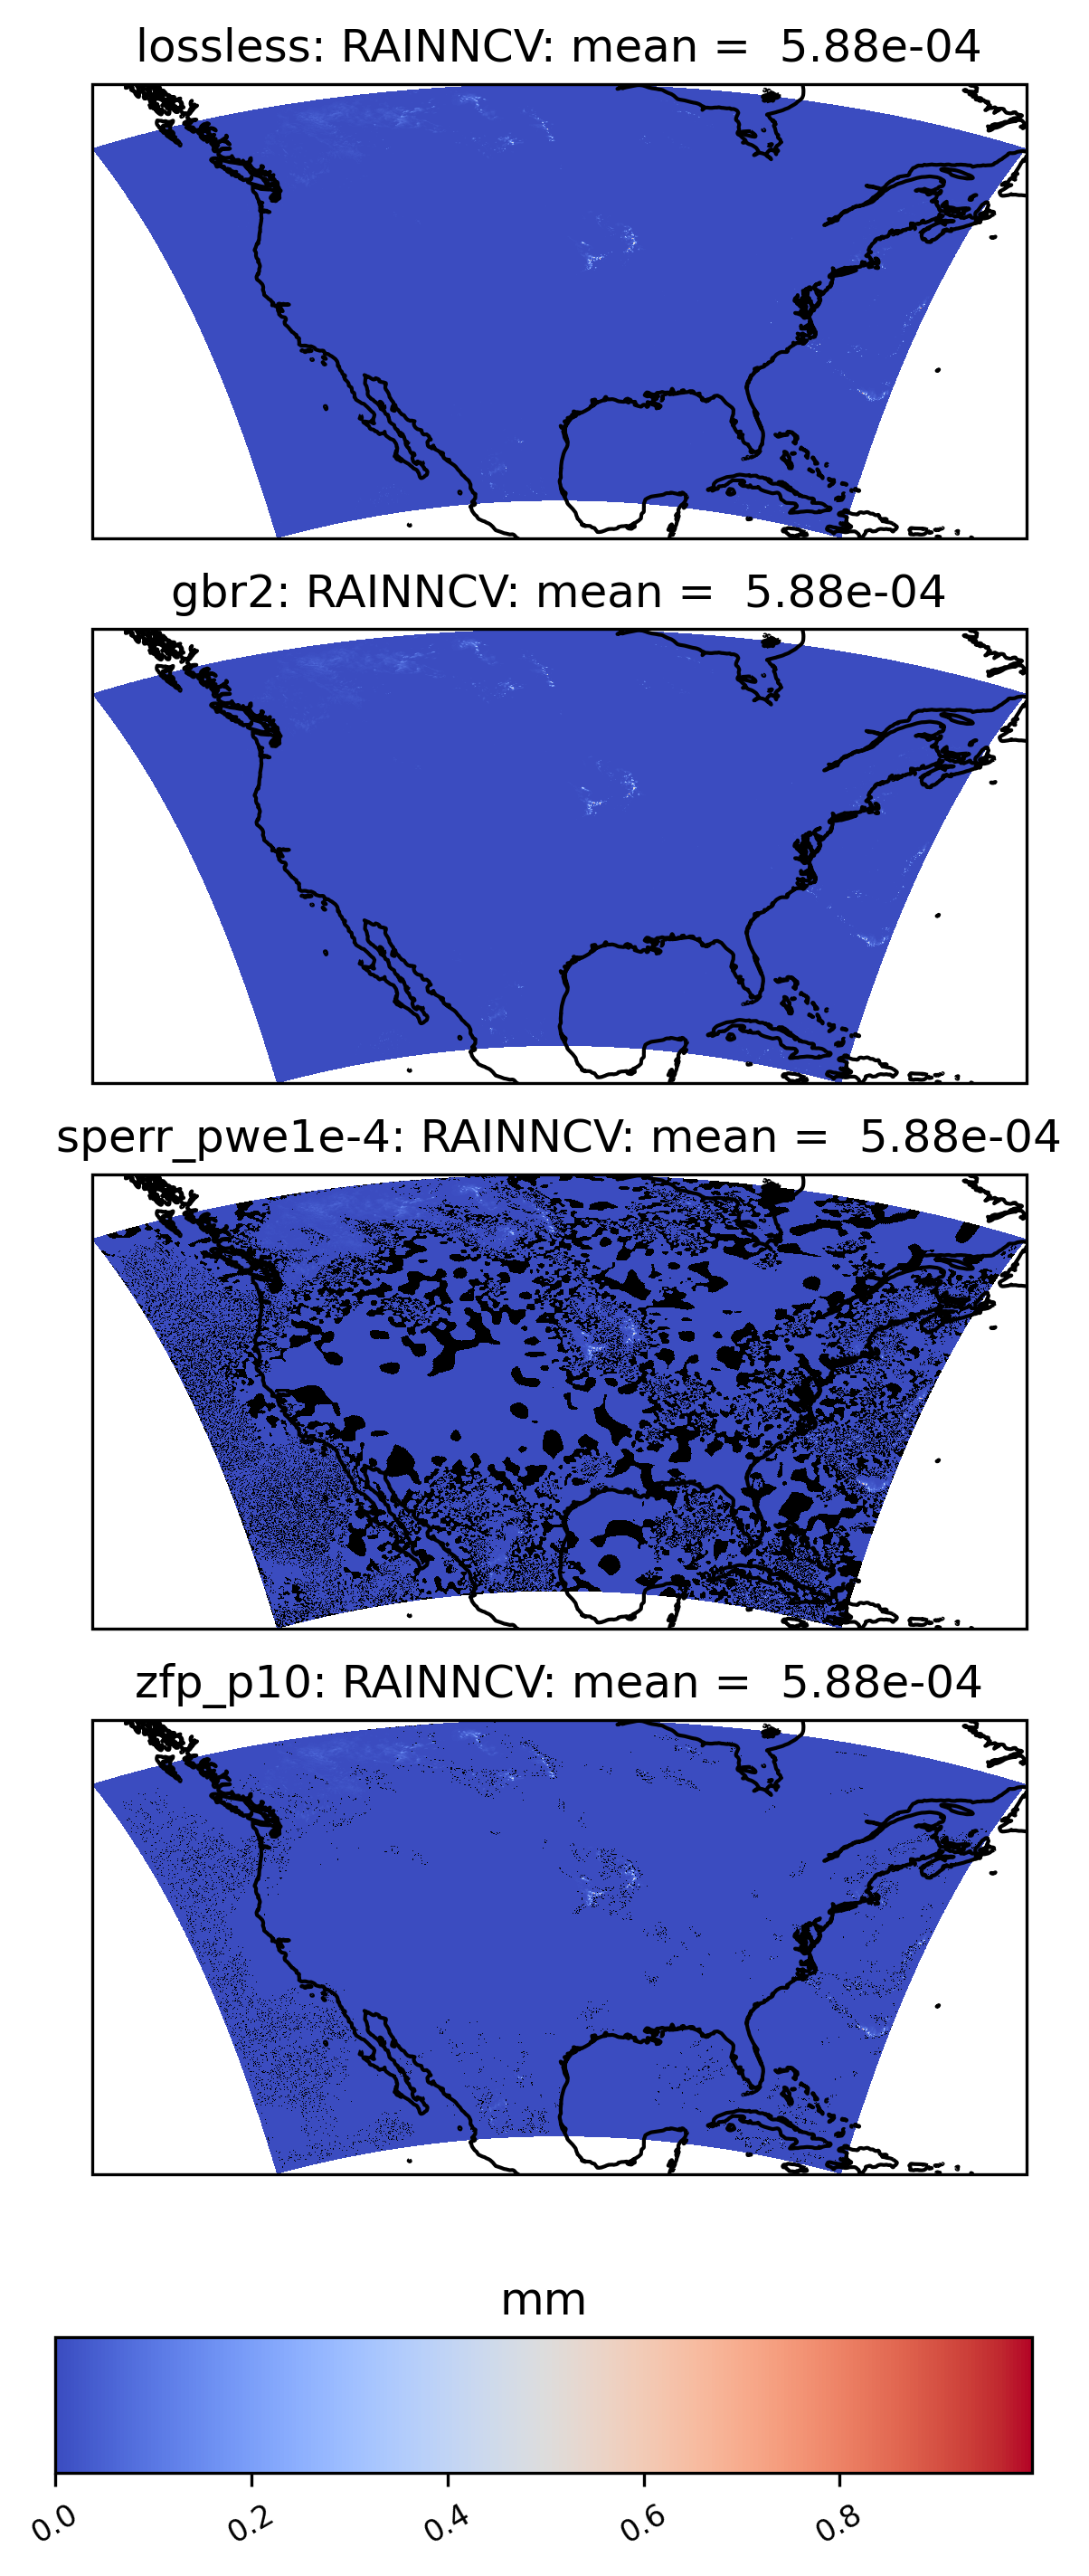

In [18]:
# do some plots for rain
# Plot  RAINNCV, with DSSIM > .995
ldcpy.plot(
    combine_col,
    "RAINNCV",
    sets=["lossless", "gbr2", "sperr_pwe1e-4", "zfp_p10"],
    calc="mean",
    plot_type="spatial",
    vert_plot=True,
)

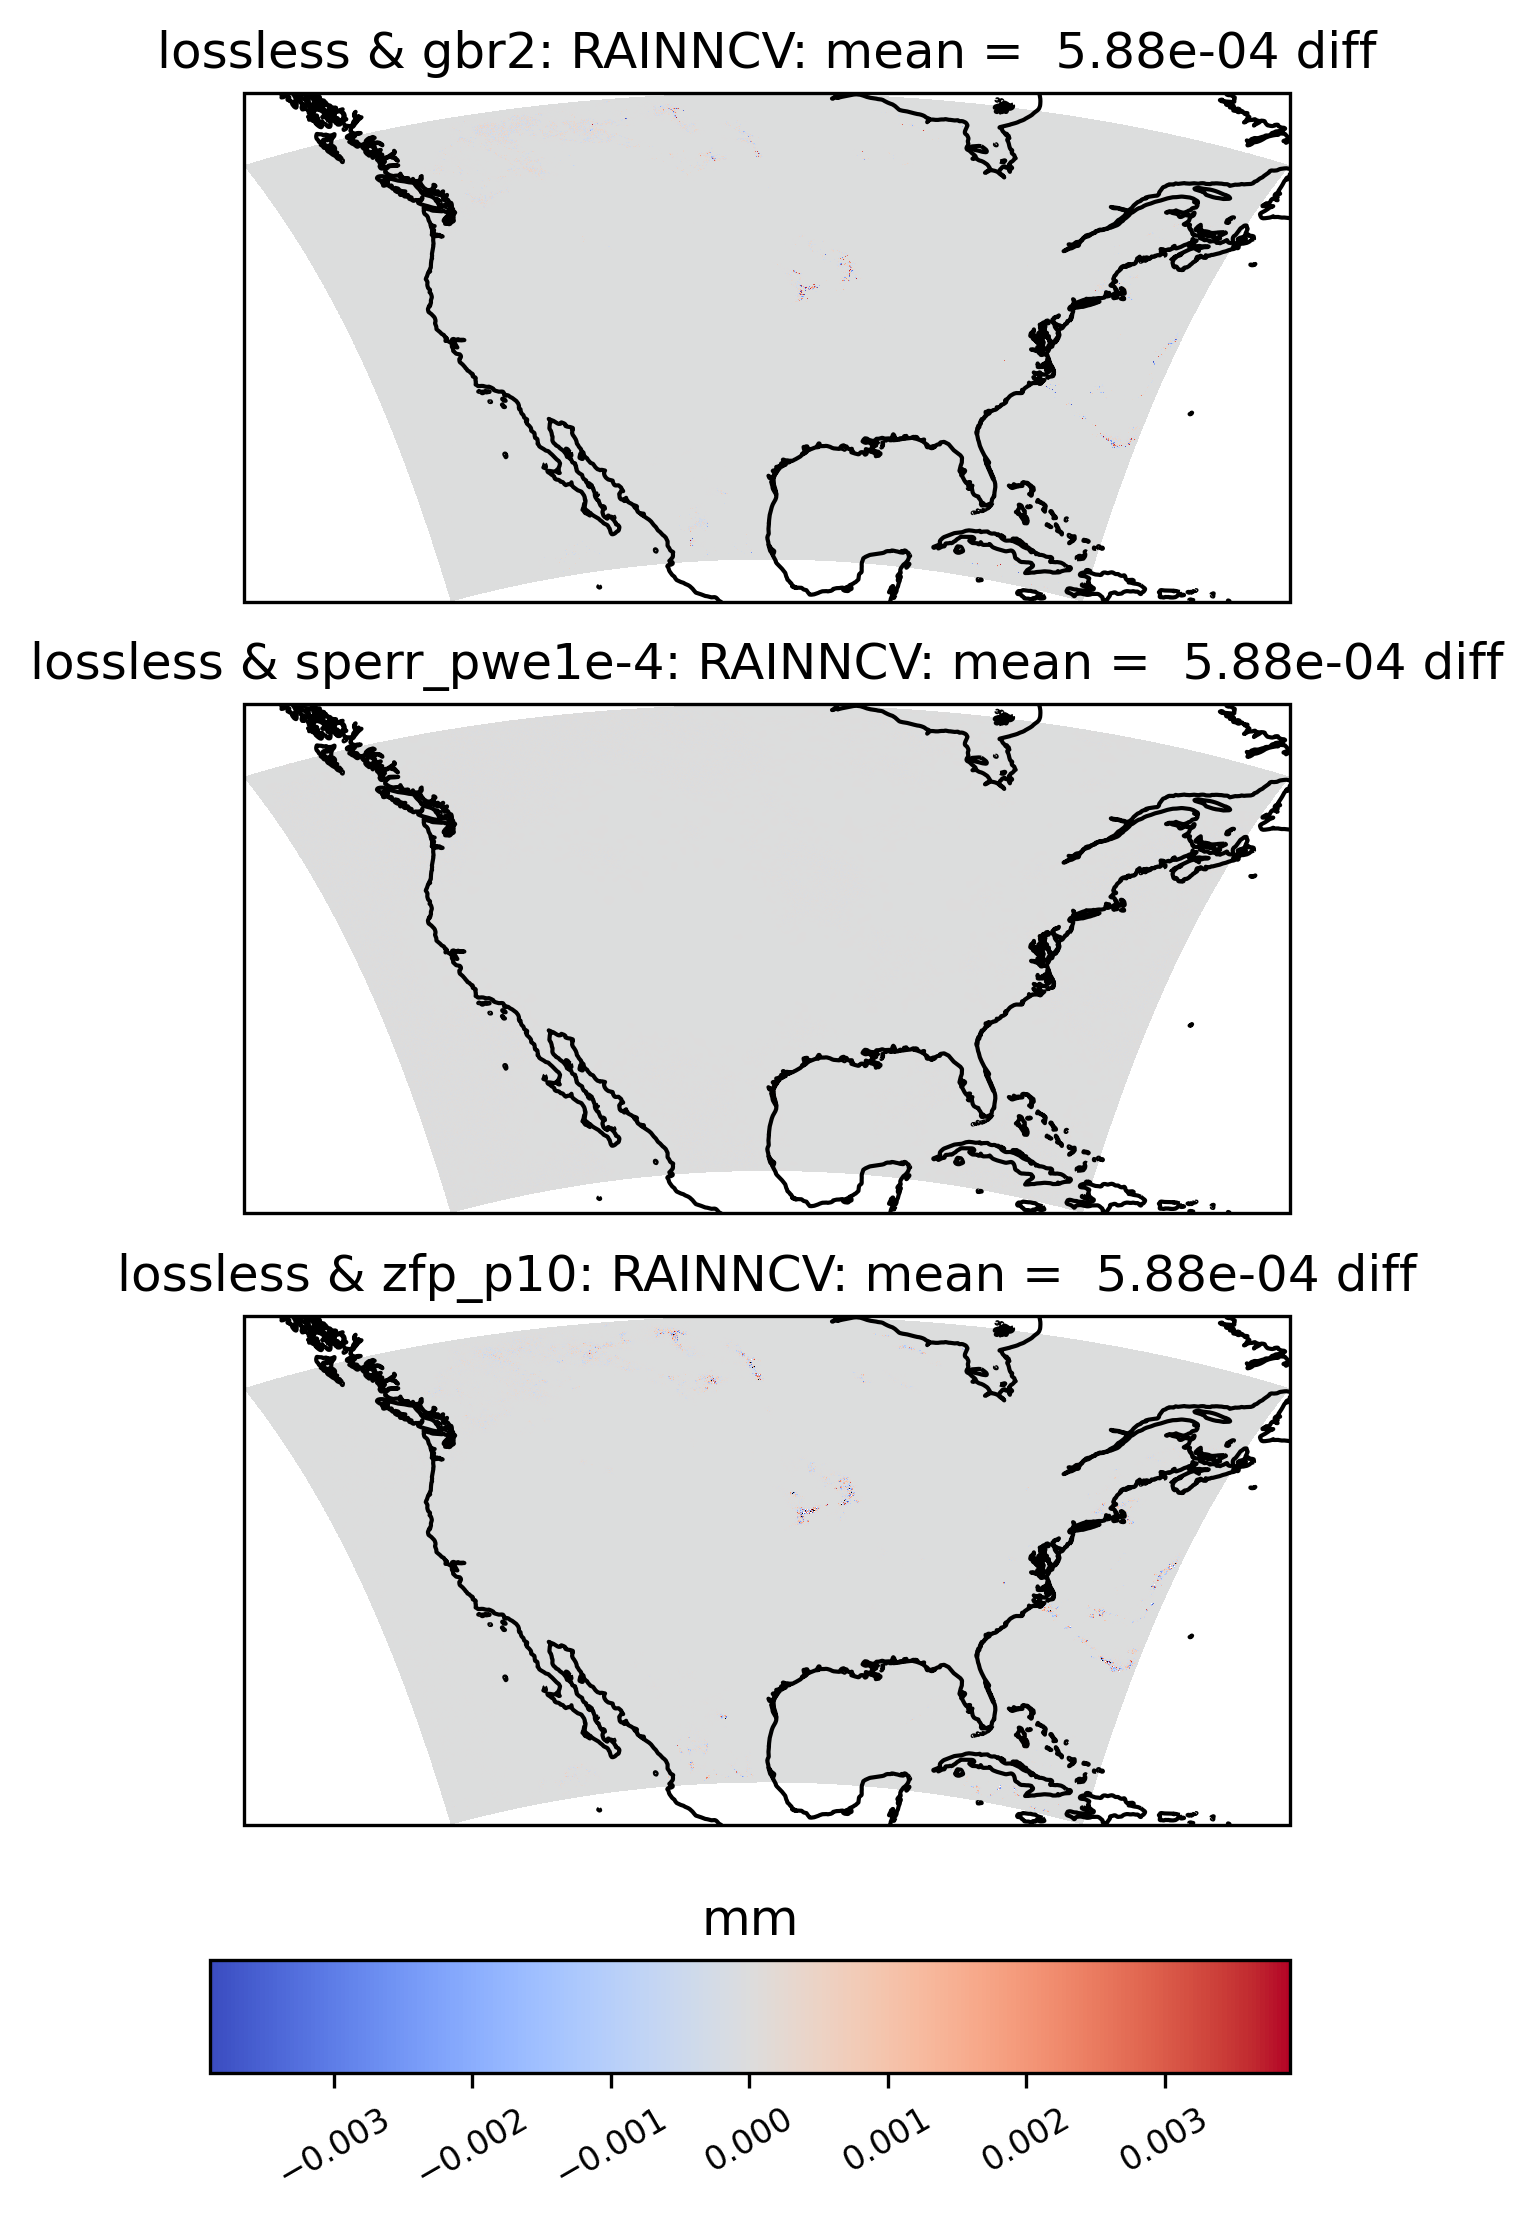

In [14]:
# do some plots for rain
# Plot the differences for RAINNCV, with DSSIM > .995
ldcpy.plot(
    combine_col,
    "RAINNCV",
    sets=["lossless", "gbr2", "sperr_pwe1e-4", "zfp_p10"],
    calc="mean",
    calc_type="diff",
    plot_type="spatial",
    vert_plot=True,
)

In [17]:
# let's put results for RAINNCV with similar DSSIM in the same table
ldcpy.compare_stats(
    col_time,
    "RAINNCV",
    ["lossless", "gbr2", "sperr_pwe1e-4", "zfp_p10"],
    significant_digits=5,
    aggregate_dims=["y", "x"],
)

lossless        gbr2 sperr_pwe1e-4  \
mean                             0.00058815  0.00058814    0.00058815   
variance                         6.2212e-05  6.2205e-05    6.2212e-05   
standard deviation                0.0078875    0.007887     0.0078875   
min value                                 0           0    -9.996e-05   
min (abs) nonzero value          1.3019e-12  1.3074e-12    2.5798e-14   
max value                           0.99651           1       0.99659   
probability positive                0.25657     0.25657       0.58078   
number of zeros                  1.0315e+06  1.0315e+06             0   
99% real information cutoff bit          31          14            10   
entropy estimate                    0.16069    0.072926       0.54679   

                                    zfp_p10  
mean                             0.00058794  
variance                         6.2245e-05  
standard deviation                0.0078895  
min value                         -0.010742  
min (abs) nonzero value          3.5527e-15  
max value                            0.9939  
probability positive                0.31836  
number of zeros                  8.2305e+05  
99% real information cutoff bit          20  
entropy estimate                    0.12962

gbr2 sperr_pwe1e-4     zfp_p10
max abs diff                         0.0039034    9.9997e-05     0.01354
min abs diff                                 0    2.5798e-14           0
mean abs diff                       5.0007e-06    1.0215e-05  1.0217e-05
mean squared diff                   2.9274e-16    5.9775e-17  4.5787e-14
root mean squared diff              7.3378e-05    1.8903e-05  0.00012681
normalized root mean squared diff   7.3635e-05    1.8969e-05  0.00012725
normalized max pointwise error       0.0039171    0.00010035     0.01333
pearson correlation coefficient        0.99996             1     0.99987
ks p-value                             0.16502             0           0
spatial relative error(% > 0.0001)      25.393        25.543      25.598
max spatial relative error            0.047607    2.0399e+07  1.9675e+08
DSSIM                                  0.99892       0.99822      0.9989
file size ratio                           3.42          1.19        3.21